<a href="https://colab.research.google.com/github/Hayato009/Signate_CrowdFunding/blob/main/Signate_CrowdFunding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U scikit-learn pandas numpy xfeat texthero category_encoders lightgbm

In [18]:
### 1. ライブラリ、データの読み込み
# ライブラリ読み込み

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from lightgbm import LGBMModel
import lightgbm as lgb

import texthero as hero
from texthero import preprocessing as pp

import xfeat
import category_encoders as ce
from scipy.optimize import minimize

In [28]:
# データの読み込み：自前のドライブより
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/My Drive/Signate/train.csv')
test = pd.read_csv('/content/drive/My Drive/Signate/test.csv')
sample_sub = pd.read_csv('/content/drive/My Drive/Signate/sample_submit.csv', header=None)

X_test = test.copy()
X_train = train[[col for col in train.columns if col not in 'state']].copy()
y_train = train['state'].copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
### 2. 特徴量エンジニアリング

## 'goal'の表記揺れを直し、min, maxを作る関数
def get_goals(X_init):
  # 100000+を100000-100000に変更
  output = X_init['goal'].copy()
  output = output.replace('100000+', '100000-100000')

  # goalをgoal_minとgoal_maxに分割
  output = np.array([g.split('-') for g in output] , dtype='int')
  output = pd.DataFrame(output, columns=['goal_min', 'goal_max'])
  return output

## テキスト内の埋め込み動画の有無を判定するカラムをつくる関数
# 特徴量操作の簡単のため、dtypeをobjectにしておく
def get_video(X_init):  
  video = []
  for text in X_init['html_content']:
    video.append("動画" in text)
  video = pd.DataFrame(video, columns=['video']).astype(int).astype(str)
  return video

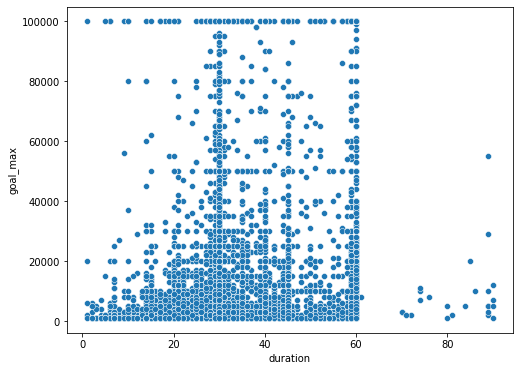

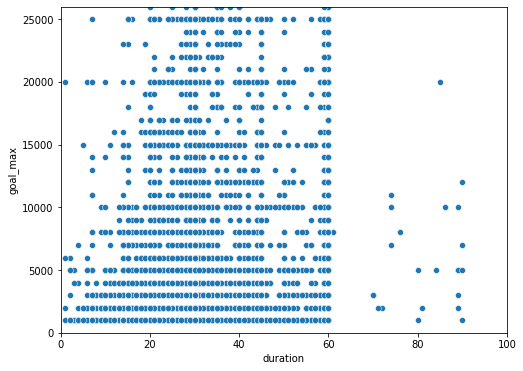

In [33]:
# binningの必要があるか視覚的に確認
# goalの~20000あたりは密集してるので、拡大してみてみる。

X_train_temp = pd.concat([X_train, get_goals(X_train)], axis=1)

plt.figure(figsize=(8,6))
sns.scatterplot(data=X_train_temp, x='duration', y='goal_max')
plt.show()

plt.figure(figsize=(8,6))
plt.ylim(0, 26000)
plt.xlim(0, 100)
sns.scatterplot(data=X_train_temp, x='duration', y='goal_max')
plt.show()

In [8]:
# goal_maxは"-1, 20k, 50k, 80k, 100k"という別れ方をしているように見える。
# durationは"-1, 30, 45, 60, それ以上"の分割が分かりやすい。

## goal_max, durationのbinningを行う関数
# --------------------------------------注：dypes: category? .astype(str)で変更してみたが…。
def get_bins(X_init):
  # goal_maxのbinを取得
  goals_df = get_goals(X_init)
  goal_max_df = goals_df['goal_max']
  goal_bin = pd.cut(goal_max_df, 
                    [-1, 19999, 49999, 79999, 99999, np.inf],
                    labels=['bin1', 'bin2', 'bin3', 'bin4', 'bin5'])
  goal_bin_df = pd.DataFrame(goal_bin).rename(columns={'goal_max': 'goal_max_bin'}).astype(object)

  # durationのbinを取得
  duration_df = X_init['duration']
  duration_bin = pd.cut(duration_df, 
                        [-1, 30, 45, 60, np.inf],
                        labels=['bin1', 'bin2', 'bin3', 'bin4'])
  duration_bin_df = pd.DataFrame(duration_bin).rename(columns={'duration': 'duration_bin'}).astype(object)
  
  output = pd.concat([goal_bin_df, duration_bin_df], axis=1)
  return output

In [9]:
## カテゴリ変数のcross-featuresを作る関数
def get_cat_cross(X_init):
  X_init = pd.concat([
             X_init, 
             get_goals(X_init),
             get_video(X_init),
             get_bins(X_init),
  ], axis=1)
  # 追加で'category1とcategory2を組み合わせたカラムも作っておく
  X_init['category3'] = X_init['category1'] + X_init['category2']
  encoder = xfeat.Pipeline([
                            xfeat.SelectCategorical(exclude_cols=['html_content', 'goal']),
                            xfeat.ConcatCombination(drop_origin=True, 
                                                    output_prefix='_plus(', 
                                                    output_suffix=')_'),
  ])
  output = encoder.fit_transform(X_init)
  return output

## 数値変数のcross-featuresを作る関数
def get_num_cross(X_init):
  X_init = pd.concat([
                      X_init, 
                      get_goals(X_init)
  ], axis=1)

  # num_cols = ['duration', 'goal_max', 'goal_min']
  output = pd.DataFrame()
  output['_mul(durationgoal_max)_'] = X_init['duration'] * X_init['goal_max']
  output['_mul(durationgoal_min)_'] = X_init['duration'] * X_init['goal_min']
  output['_dev(goal_maxduration)_'] = X_init['goal_max'] / X_init['duration']
  output['_dev(goal_minduration)_'] = X_init['goal_min'] / X_init['duration']
  return output

## カテゴリ変数をLabel encodingした特徴量を得る関数
def get_labelencoded_features(X_init):
  video = get_video(X_init)
  bins = get_bins(X_init)
  cat_cross = get_cat_cross(X_init)
  cat_df = pd.concat([
                      X_init[['country', 'category1', 'category2']],
                      video,
                      bins,
                      cat_cross,
  ], axis=1)

  encoder = ce.CountEncoder()
  output = encoder.fit_transform(cat_df).add_prefix('le_')
  return output

# ## カテゴリ変数のtarget encodingを得る関数
# # target encodingの実施結果、良い結果が出なかったのでお蔵入り
# def get_targetencoded_features(X_train, y_train, X_test):
#   output_test = pd.DataFrame()
#   output_train = pd.DataFrame()
#   # train df
#   video = get_video(X_train)
#   bins = get_bins(X_train)
#   cat_cross = get_cat_cross(X_train)
#   # ユニークな要素数が多い、つまり区分と目的関数が一対一対応してしまう可能性が高いカラムを省く。
#   # safe_cols = [col for col in cat_cross.columns if cat_cross[col].nunique() <= 400]
#   cat_train = pd.concat([
#                       X_train[['country', 'category1', 'category2']],
#                       video,
#                       bins,
#                       cat_cross,
#   ], axis=1)
#   li_cols = cat_train.columns.to_list()

#   # test df  
#   video = get_video(X_test)
#   bins = get_bins(X_test)
#   cat_cross = get_cat_cross(X_test)
#   cat_test = pd.concat([
#                       X_test[['country', 'category1', 'category2']],
#                       video,
#                       bins,
#                       cat_cross,
#   ], axis=1)

#   for c in li_cols:
#     # 学習データ全体で各カテゴリでのtargetの平均を計算
#     data_tmp = pd.DataFrame({c: cat_train[c], 'target': y_train})
#     target_mean = data_tmp.groupby(c)['target'].mean()
#     # テストデータのカテゴリを置換
#     output_test["te_"+c] = cat_test[c].map(target_mean)

#     # 学習データの変換後の値を格納する配列
#     tmp = np.repeat(np.nan, X_train.shape[0]) 

#     # 学習データの分割
#     kf = KFold(5, shuffle=True, random_state=0)
#     for idx_1, idx_2 in kf.split(cat_train):
#       # out-of-foldで各カテゴリにおける目的変数の平均を計算
#       target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
#       # 変換後の値を一時配列に格納
#       tmp[idx_2] = cat_train[c].iloc[idx_2].map(target_mean)

#     # 変換後のデータで元の変数を置換
#     output_train["te_"+c] = tmp
#   # 欠損値を-1で埋める
#   output_test = output_test.fillna(-1)
#   output_train = output_train.fillna(-1)
#   # 値が1や0であるもの(Leakしている)が全体の5%未満であるものだけ使用してみる
#   safe_cols = [col for col in tr.columns if (tr[col] == 1).sum() <= 500]
#   output_test = output_test[safe_cols]
#   output_train = output_train[safe_cols]
#   return output_train, output_test

## 集約特徴量を作る関数
def get_agg(X_init):
  X_init = pd.concat([
            X_init,
            get_goals(X_init),
            get_video(X_init),
            get_bins(X_init),
            get_cat_cross(X_init),
            get_num_cross(X_init),
  ], axis=1).drop(['id', 'html_content', 'goal'], axis=1)

  cat_cols = [col for col in X_init.columns if X_init[col].dtype == object]
  num_cols = [col for col in X_init.columns if not X_init[col].dtype == object]

  output = pd.DataFrame()
  for cat_col in cat_cols:
    agg_df, agg_cols = xfeat.aggregation(
        X_init,
        group_key=cat_col,
        group_values=num_cols,
        agg_methods=['std'],
    )
    output = pd.concat([output, agg_df[agg_cols]], axis=1)
  return output

In [10]:
# 以下、html_content処理用の関数群
# textの基本的な情報を取ってくる関数
def get_textfeatures(df, column, name):
  output = pd.DataFrame()
  output[name + column + '_num_chars'] = df[column].apply(len)
  output[name + column + '_num_punctuation'] = df[column].apply(lambda x: sum(x.count(w) for w in '.,;:'))
  output[name + column + '_num_symbols'] = df[column].apply(lambda x: sum(x.count(w) for w in '*&$%'))
  output[name + column + '_num_words'] = df[column].apply(lambda x: len(x.split()))
  output[name + column + '_num_unique_words'] = df[column].apply(lambda x: len(set(w for w in x.split())))
  output['/' + name + column + '_num_unique_words' + name + column + '_num_words/'] = output[name + column + '_num_unique_words'] / output[name + column + '_num_words']
  output['/' + name + column + '_num_words' + name + column + '_num_chars/'] = output[name + column + '_num_words'] / output[name + column + '_num_chars']
  return output

# ## 文章に関する特徴量についてのcross-featuresをつくる関数
# # '_dev(_mul(durationgoal_max)_rawhtml_content_num_punctuation)_'のみ作ればいいことが
# # 判明したのでコメントアウト
# def get_num_cross_2(X_init, name):
#   t = pd.concat([X_init, 
#                get_goals(X_init), 
#                get_num_cross(X_init), 
#                get_textfeatures(X_init, 'html_content', name)], axis=1)
#   # 積の特徴量
#   encoder1 = xfeat.Pipeline([
#                             xfeat.SelectNumerical(exclude_cols=['id']), # ----- 入力Xによって操作！
#                             xfeat.ArithmeticCombinations(
#                                 drop_origin=True,
#                                 operator='*',
#                                 output_prefix='_mul(',
#                                 output_suffix=')_',
#                                 r=2,
#                             ),
#   ])
#   # 比の特徴量
#   encoder2 = xfeat.Pipeline([
#                             xfeat.SelectNumerical(exclude_cols=['id']), # ----- 入力Xによって操作！
#                             xfeat.ArithmeticCombinations(
#                                 drop_origin=True,
#                                 operator='/',
#                                 output_prefix='_dev(',
#                                 output_suffix=')_',
#                                 r=2,
#                             ),                   
#   ])
#   encoded_df1 = encoder1.fit_transform(t)
#   encoded_df2 = encoder2.fit_transform(t)
#   encoded_df = pd.concat([encoded_df1, encoded_df2], axis=1)
#   return encoded_df

# textの次元削減したtfidfを取ってくる関数
def get_tfidf(dataframe, name):
  vec = TfidfVectorizer().fit_transform(dataframe['html_content'])
  output = TruncatedSVD(n_components=64, random_state=0).fit_transform(vec)
  output = pd.DataFrame(output, columns=[name + str(i) for i in range(64)])
  return output

# 元テキストの基本特徴量とtfidfをとってくる関数
def get_raw_textfeatures(X_init, column, name):
  textfeatures = get_textfeatures(X_init, column, name)
  tfidf = get_tfidf(X_init, name)
  output = pd.concat([textfeatures, tfidf], axis=1)
  return output

# テキストの体裁を整える関数
def clean_partial(X_init):
    custom_pipeline = [pp.fillna,
                   pp.lowercase,
                   # pp.remove_html_tags,
                   pp.remove_punctuation,
                   pp.remove_diacritics,
                   pp.remove_digits,
                   pp.remove_stopwords,
                   pp.remove_whitespace,
                   pp.stem]
    output = pd.DataFrame(hero.clean(X_init['html_content'], custom_pipeline))
    return output

## 体裁を整えた文章の基本特徴量とtfidfをとってくる関数
def get_fairlypreprocessed_textfeatures(X_init, column, name):
  fairlypreprocessed_texts = clean_partial(X_init)
  textfeatures = get_textfeatures(fairlypreprocessed_texts, column, name)
  tfidf = get_tfidf(fairlypreprocessed_texts, name)
  output = pd.concat([textfeatures, tfidf], axis=1)
  return output

# テキストの体裁を整えた上でhtmlタグを消去する関数
def clean_all(X_init):
    custom_pipeline = [pp.fillna,
                   pp.remove_html_tags,
                   pp.lowercase,
                   pp.remove_punctuation,
                   pp.remove_diacritics,
                   pp.remove_digits,
                   pp.remove_stopwords,
                   pp.remove_whitespace,
                   pp.stem]
    output = pd.DataFrame(hero.clean(X_init['html_content'], custom_pipeline))
    return output

## テキストの体裁を整えてhtmlタグも消去した文章の基本特徴量とtfidfを取ってくる関数
def get_wellpreprocessed_textfeatures(X_init, column, name):
  wellpreprocessed_texts = clean_all(X_init)
  textfeatures = get_textfeatures(wellpreprocessed_texts, column, name)
  tfidf = get_tfidf(wellpreprocessed_texts, name)
  output = pd.concat([textfeatures, tfidf], axis=1)
  return output


In [11]:
## こまごまとした関数たち
def make_skf(X_train, y_train, random_state=0):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    folds_idx = [(t, v) for (t, v) in skf.split(X_train, y_train)]
    return folds_idx

# 最適な閾値を求める関数
def threshold_optimization(y_true, y_pred, metrics=None):
    def f1_opt(x):
        if metrics is not None:
            score = -metrics(y_true, y_pred >= x)
        else:
            raise NotImplementedError
        return score
    result = minimize(f1_opt, x0=np.array([0.5]), method='Nelder-Mead')
    best_threshold = result['x'].item()
    return best_threshold

# 最適なf1を得る関数
def optimized_f1(y_true, y_pred):
    bt = threshold_optimization(y_true, y_pred, metrics=f1_score)
    score = f1_score(y_true, y_pred >= bt)
    return score

In [12]:
### 3. モデル設計
class MyLGBMModel:
    def __init__(self, name=None, params=None, fold=None, X_train=None, y_train=None, X_test=None, metrics=None, seeds=None, blend_train=None, blend_test=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.name = name
        self.params = params
        self.metrics = metrics  # metrics で定義した関数
        self.kfold = fold  # make fold で定義した関数
        self.oof = None
        self.preds = None
        self.seeds = seeds if seeds is not None else [2020]  # seed average用のseed値
        self.blend_train = blend_train
        self.blend_test = blend_test
        self.models = {}  # 学習済みモデルを保持

    def build_model(self):
        model = LGBMModel(**self.params)
        return model

    # validationに対する予測を出力
    def predict_cv(self):
        oof_seeds = []
        scores_seeds = []
        for seed in self.seeds:
            oof = []
            va_idxes = []
            scores = []
            X_train = self.X_train.values
            y_train = self.y_train.values
            fold_idx = self.kfold(self.X_train, self.y_train, random_state=seed) 

            # train and predict by cv folds
            for cv_num, (tr_idx, va_idx) in enumerate(fold_idx):
                X_tr, X_va = X_train[tr_idx], X_train[va_idx]
                y_tr, y_va = y_train[tr_idx], y_train[va_idx]
                va_idxes.append(va_idx)
                model = self.build_model()
    
                # fitting - train
                model.fit(X_tr, y_tr,
                          eval_set=[[X_va, y_va]],
                          eval_metric='f1_score', # --------追加
                          early_stopping_rounds=100,
                          verbose=False) 
                model_name = f"{self.name}_SEED{seed}_FOLD{cv_num}_model.pkl"
                self.models[model_name] = model  # save model
                
                # predict - validation
                pred = model.predict(X_va)
                oof.append(pred)

                 # validation score
                score = self.get_score(y_va, pred)
                scores.append(score)
                print(f"SEED:{seed}, FOLD:{cv_num} =====> val_score:{score}")

            # sort as default
            va_idxes = np.concatenate(va_idxes)
            oof = np.concatenate(oof)
            order = np.argsort(va_idxes)
            oof = oof[order]
            oof_seeds.append(oof)
            scores_seeds.append(np.mean(scores))
            
        oof = np.mean(oof_seeds, axis=0)
        self.oof = oof
        print(f"model:{self.name} score:{self.get_score(self.y_train, oof)}\n")
        return oof

    def inference(self):
        preds_seeds = []
        for seed in self.seeds:
            preds = []
            X_test = self.X_test.values
            # train and predict by cv folds
            for cv_num in range(5): ##------------------------ 注：foldの数を手入力している
                print(f"-INFERENCE- SEED:{seed}, FOLD:{cv_num}")
                # load model
                model_name = f"{self.name}_SEED{seed}_FOLD{cv_num}_model.pkl"
                model = self.models[model_name]
                # predict - test data
                pred = model.predict(X_test)
                preds.append(pred)
            preds = np.mean(preds, axis=0)
            preds_seeds.append(preds)
        preds = np.mean(preds_seeds, axis=0)
        self.preds = preds
        return preds

    def get_blend_data(self): # --------------------------------------------blending
      best_threshold = threshold_optimization(y_true=y_train, y_pred=oof, metrics=f1_score) 

      self.blend_train[self.name] = self.oof >= best_threshold
      self.blend_test[self.name] = self.preds >= best_threshold
      blend_train = self.blend_train.astype(int)
      blend_test = self.blend_test.astype(int)
      return blend_train, blend_test

    def tree_importance(self):
        feature_importance_df = pd.DataFrame()
        for i, (tr_idx, va_idx) in enumerate(self.kfold(self.X_train, self.y_train)):
            print("FOLD:", str(i+1), "/5")
            tr_x, va_x = self.X_train.values[tr_idx], self.X_train.values[va_idx]
            tr_y, va_y = self.y_train.values[tr_idx], self.y_train.values[va_idx]
            model = self.build_model()
            model.fit(tr_x, tr_y,
                      eval_set=[[va_x, va_y]],
                      early_stopping_rounds=100,
                      verbose=False) # 今回はみやすさのためoffにしてます(お好みで)
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importances_
            _df['column'] = self.X_train.columns
            _df['fold'] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

        return feature_importance_df

    def get_score(self, y_true, y_pred):
        score = self.metrics(y_true, y_pred)
        return score

In [13]:
### 4. 前処理実施
# 今回はルール的に可能なので。trainとtestを一緒に処理してしまう
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)

goals = get_goals(X_all)
le_features = get_labelencoded_features(X_all)
num_cross = get_num_cross(X_all)
agg = get_agg(X_all)
raw_textfeatures = get_raw_textfeatures(X_all, 'html_content', '_raw')
fp_textfeatures = get_fairlypreprocessed_textfeatures(X_all, 'html_content', '_fp')
wp_textfeatures = get_wellpreprocessed_textfeatures(X_all, 'html_content', '_wp')

X_all = pd.concat([
                   goals,
                   le_features,
                   num_cross,
                   agg,
                   raw_textfeatures,
                   fp_textfeatures,
                   wp_textfeatures,
], axis=1)
X_all['_dev(_mul(durationgoal_max)_rawhtml_content_num_punctuation)_'] =\
num_cross['_mul(durationgoal_max)_'] / raw_textfeatures['_rawhtml_content_num_punctuation']

X_train_pp = X_all.iloc[:len(train)]
X_test_pp = X_all.iloc[len(train):].reset_index(drop=True)

In [14]:
### 5. 必要な特徴量重要度を選定
model_params = {
    "n_estimators": 10000,
    "objective": 'binary',
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
}

model = MyLGBMModel(name='lgb1', 
                    params=model_params,
                    fold=make_skf,  # make folds
                    X_train=X_train_pp,
                    y_train=y_train,
                    X_test=X_test_pp,
                    metrics=optimized_f1, # define metrics
                    seeds=[0, 1, 2]  # 3 seeds average
                   )

# feature importance
importance_df = model.tree_importance() # 重要な特徴量に関するデータ


FOLD: 1 /5
FOLD: 2 /5
FOLD: 3 /5
FOLD: 4 /5
FOLD: 5 /5


In [15]:
importance_df.groupby('column').mean().reset_index()\
.sort_values('feature_importance', ascending=False).head(50)

,column,feature_importance,fold
6,_dev(_mul(durationgoal_max)_rawhtml_content_nu...,52810.132487,3
290,agg_std__mul(durationgoal_max)__grpby__plus(vi...,19427.609932,3
321,agg_std__mul(durationgoal_min)__grpby_category2,14173.012566,3
294,agg_std__mul(durationgoal_max)__grpby_category2,7896.315669,3
79,_mul(durationgoal_min)_,6681.768465,3
317,agg_std__mul(durationgoal_min)__grpby__plus(vi...,6143.244461,3
80,_raw0,5683.681707,3
409,le__plus(category1category2)_,5567.081807,3
72,_fp9,5478.365128,3
326,agg_std_duration_grpby__plus(category1category2)_,4896.180266,3


In [16]:
### 6. モデル評価

# Generalized stacking用データフレーム(今回は時間が足りず未使用)
blend_train = pd.DataFrame()
blend_test = pd.DataFrame()

model1 = MyLGBMModel(name='lgb1', 
                    params=model_params,
                    fold=make_skf,  # make folds
                    X_train=X_train_pp,
                    y_train=y_train,
                    X_test=X_test_pp,
                    metrics=optimized_f1, # define metrics
                    seeds=[0, 1, 2],  # 3 seeds average
                    blend_train=blend_train,
                    blend_test=blend_test,
                   )

selected_num = 200
cols = importance_df.groupby('column').mean().reset_index().sort_values('feature_importance', ascending=False)['column'].tolist()
selected_cols = cols[:selected_num]
model1.X_train = X_train_pp[selected_cols].copy()
model1.X_test = X_test_pp[selected_cols].copy()

# cross-validation and predict
oof = model1.predict_cv() 
preds = model1.inference()

# best threshold
best_threshold = threshold_optimization(y_true=y_train, y_pred=oof, metrics=f1_score) 
print(f"best_threshold is {best_threshold}\n")

# make blend data
# blend_train, blend_test = model1.get_blend_data()

SEED:0, FOLD:0 =====> val_score:0.8163074039362699
SEED:0, FOLD:1 =====> val_score:0.8176277543366152
SEED:0, FOLD:2 =====> val_score:0.8130883012102197
SEED:0, FOLD:3 =====> val_score:0.816233470132239
SEED:0, FOLD:4 =====> val_score:0.8104693140794224
SEED:1, FOLD:0 =====> val_score:0.8198986642100415
SEED:1, FOLD:1 =====> val_score:0.8157293095564702
SEED:1, FOLD:2 =====> val_score:0.818931828050369
SEED:1, FOLD:3 =====> val_score:0.8113475177304964
SEED:1, FOLD:4 =====> val_score:0.7992315081652257
SEED:2, FOLD:0 =====> val_score:0.8276181649675625
SEED:2, FOLD:1 =====> val_score:0.8088930936613057
SEED:2, FOLD:2 =====> val_score:0.795260663507109
SEED:2, FOLD:3 =====> val_score:0.8159927305770106
SEED:2, FOLD:4 =====> val_score:0.8048895157498825
model:lgb1 score:0.817255735671893

-INFERENCE- SEED:0, FOLD:0
-INFERENCE- SEED:0, FOLD:1
-INFERENCE- SEED:0, FOLD:2
-INFERENCE- SEED:0, FOLD:3
-INFERENCE- SEED:0, FOLD:4
-INFERENCE- SEED:1, FOLD:0
-INFERENCE- SEED:1, FOLD:1
-INFERENCE- S

In [17]:
### 7. 予測データ出力
output = pd.DataFrame({'id': sample_sub[0], 'preds': (preds >= best_threshold).astype(int)})

output.to_csv('output.csv', index=False, header=False)